In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt
import functools
from functools import partial, wraps
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
from scipy import signal
from torch.nn.modules.linear import Linear
from operator import mul
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
import joblib
# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

import warnings

warnings.filterwarnings("ignore")

# 基于LSTM（长短时记忆）的时间序列预测

**LSTM不能实现多输入多输出任务，可以通过其他渠道实现，可以改为多输入预测多个单输出，即建立多个多输入单输出模型。**

## 多输入单输出多步预测

### 数据准备

In [198]:
# 读取数据
def get_dataset(data_path=None, data=None, time_col=None):
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [199]:
data_path = "../test/datasets/energy.csv"
ts_data = get_dataset(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [200]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list, scaler_path):
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.transform(test)
    xte = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.transform(yte)
    yte = yte.values.astype('float32')
    
    # 数据合并，[训练集，测试集，时间戳]
    train = [xtr, ytr]
    valid = [xva, yva]
    test = [xte, yte]
    
    return x_scaler, y_scaler, train, valid, test

In [201]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ['temp'],
    "scaler_path": '../test/scalers/LSTM'
}

#函数传参
x_scaler, y_scaler, train, valid, test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(train[0].shape, train[1].shape))
print("x_valid shape: {0} y_valid shape: {1}".format(valid[0].shape, valid[1].shape))
print("x_test shape: {0} y_test shape: {1}".format(test[0].shape, test[1].shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [202]:
#利用前seq_len个数据，预测下pred_len个数据
def rnn_create_dataset(data_list, seq_len, pred_len, batch_size):
    """
    @参数设置：
    data_list：特征，目标，时间戳
    seq_len：输入数据包含过去多少个时间步
    pred_len：目标应该在未来多少个时间步之后
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(feat)
        y.append(tar)
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    y = y.squeeze(dim=2) # 去掉维度为1的第三维度，将其变为二维

    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    
    return X, y, data_loader

In [203]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "batch_size": 32,
}
X_train, y_train, train_loader = rnn_create_dataset(train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3]),loader_len: 46


### 模型定义

In [204]:
# LSTM模型
class LSTM(nn.Module):
    def __init__(self, pred_len, c_in, c_out, d_model, num_layers):
        super().__init__()
        self.pred_len = pred_len
        self.lstm = nn.LSTM(input_size=c_in, hidden_size=d_model, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=d_model, out_features=c_out)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        output = x[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [205]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            outputs = outputs.squeeze(dim=2) # 删除最后一个维度，将其变为二维
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                outputs = model(batch_x)
                outputs = outputs.squeeze(dim=2) # 删除最后一个维度，将其变为二维
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:02<00:46,  2.43s/it]

Epoch [1/20], Training Loss: 0.0086, Validation Loss: 0.0028
Validation loss decreased (inf --> 0.002807).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:04<00:42,  2.36s/it]

Epoch [2/20], Training Loss: 0.0021, Validation Loss: 0.0018
Validation loss decreased (0.002807 --> 0.001768).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:07<00:39,  2.33s/it]

Epoch [3/20], Training Loss: 0.0015, Validation Loss: 0.0013
Validation loss decreased (0.001768 --> 0.001309).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:09<00:36,  2.30s/it]

Epoch [4/20], Training Loss: 0.0012, Validation Loss: 0.0012
Validation loss decreased (0.001309 --> 0.001229).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:11<00:34,  2.29s/it]

Epoch [5/20], Training Loss: 0.0010, Validation Loss: 0.0010
Validation loss decreased (0.001229 --> 0.001007).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:13<00:31,  2.27s/it]

Epoch [6/20], Training Loss: 0.0010, Validation Loss: 0.0010
Validation loss decreased (0.001007 --> 0.000962).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:16<00:29,  2.26s/it]

Epoch [7/20], Training Loss: 0.0009, Validation Loss: 0.0009
Validation loss decreased (0.000962 --> 0.000877).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [00:18<00:27,  2.26s/it]

Epoch [8/20], Training Loss: 0.0009, Validation Loss: 0.0009
Validation loss decreased (0.000877 --> 0.000874).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [00:20<00:24,  2.24s/it]

Epoch [9/20], Training Loss: 0.0008, Validation Loss: 0.0009
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [00:22<00:22,  2.24s/it]

Epoch [10/20], Training Loss: 0.0008, Validation Loss: 0.0008
Validation loss decreased (0.000874 --> 0.000792).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [00:24<00:20,  2.24s/it]

Epoch [11/20], Training Loss: 0.0008, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:27<00:17,  2.24s/it]

Epoch [12/20], Training Loss: 0.0008, Validation Loss: 0.0008
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00034549150281252633


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:29<00:19,  2.46s/it]

Epoch [13/20], Training Loss: 0.0008, Validation Loss: 0.0008
EarlyStopping counter: 3 out of 3
Early stopping!


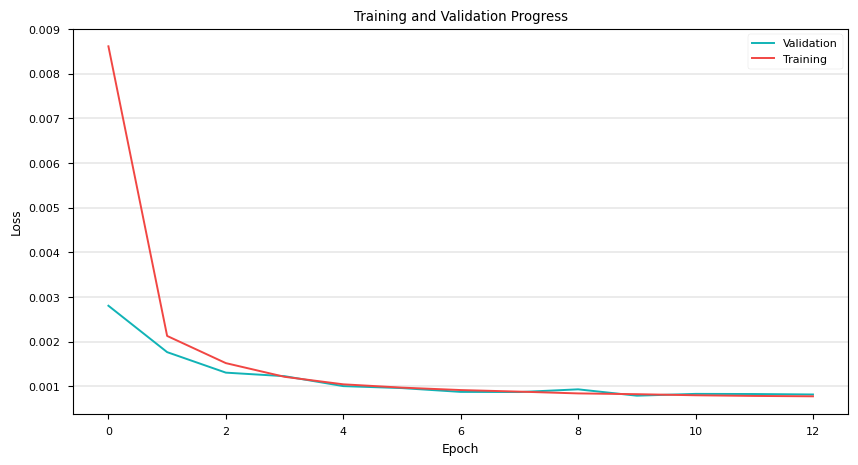

In [206]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "train_args": {
        "model_name": LSTM,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../test/best_models/LSTM",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'pred_len': 3,
        'd_model': 128,
        'c_in': 2,
        'c_out': 1,
        'num_layers': 1
    },
}
model = train(**params3)

### 模型测试

In [207]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    y_test = test_args['y_test'] 
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)
        y_pred = outputs.squeeze(dim=2) # 删除最后一个维度，将其变为二维
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [208]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "y_test": y_test,
        'device': 'cuda',
        'test_path': '../test/results/LSTM'
    }
}
res = test(**params4)

mae: 0.0159
mse: 0.0004
rmse: 0.0211
mape: 0.0364
mspe: 0.0024


### 结果分析

In [209]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_valid = plot_args['x_valid'] 
    x_test = plot_args['x_test'] 
    y_true = plot_args['y_true'] 
    scaler = plot_args['scaler']
    seq_len = plot_args['seq_len']
    pred_len = plot_args['pred_len'] 
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true[target].values
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        outputs = model(x_train)
        y_pred = outputs[:,-1, :] # 删除最后一个维度，将其变为二维
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        outputs = model(x_valid)
        y_pred = outputs[:,-1, :] # 删除最后一个维度，将其变为二维
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        outputs = model(x_test)
        y_pred = outputs[:,-1, :] # 删除最后一个维度，将其变为二维
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

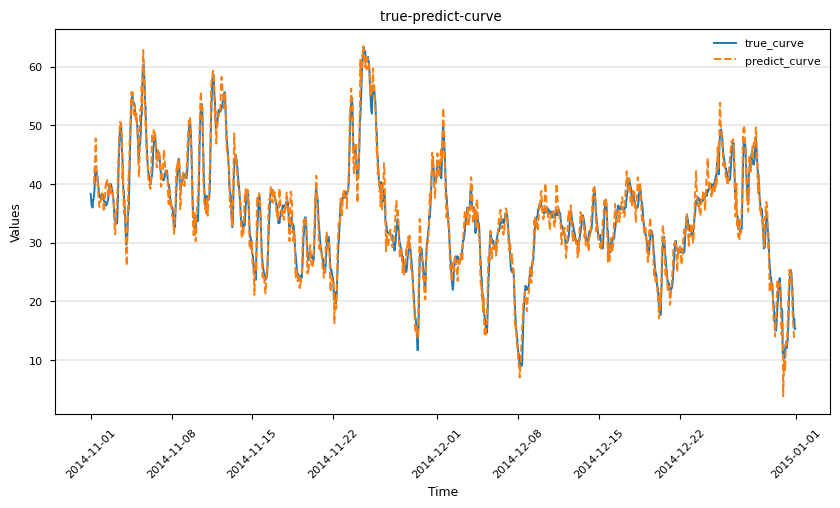

0

In [210]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "plot_args": {
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../test/images/LSTM'
    }
}
plot(**params5)

### 模型预测

In [211]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    seq_len = predict_args['seq_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = get_dataset(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(0+1), 
                            end=x_true.index[-1]+timedelta*(0+pred_len), 
                            freq=freq) 
    y_time = y_stamp

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        outputs = model(x_true)
        y_pred = outputs.squeeze(dim=2)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = y_scaler.inverse_transform(y_pred) #反归一化

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred.transpose(1, 0), index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [212]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": LSTM,
        "model_path": "../test/best_models/LSTM/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../test/scalers/LSTM',
        "device": 'cpu', 
        'seq_len': 6,
    },
    "model_args": {
        'pred_len': 3,
        'd_model': 128,
        'c_in': 2,
        'c_out': 1,
        'num_layers': 1,
    },
}
y_pred = predict(**params6)

In [213]:
y_pred

,temp
2012-01-01 06:00:00,31.045597
2012-01-01 07:00:00,34.409401
2012-01-01 08:00:00,32.119644


# 基于GRU（门控循环单元）的时间序列预测

## 模型训练

In [40]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True):
    # 定义GRU
    class GRU(nn.Module):
        def __init__(self, input_dim, out_dim):
            super().__init__()
            self.gru = nn.GRU(input_size=input_dim, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(in_features=5, out_features=out_dim) 
        def forward(self, x):
            x, _ = self.gru(x)
            x = self.linear(x)
            return x
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    #训练模型
    model = GRU(input_dim=input_dim, out_dim=out_dim).to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)[:,-1, -1:]
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)[:,-1, -1:]
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

## 模型预测

In [41]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

## 单输入单输出单步预测

In [42]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [43]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1, #确保后续画图不出错
    "batch_size": 32,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 1]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 6, 1]),y_size: torch.Size([1458, 1]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:02<00:25,  2.80s/it]

Epoch [1/10], Training Loss: 0.0122, Validation Loss: 0.0049


 20%|████████████████▌                                                                  | 2/10 [00:05<00:21,  2.67s/it]

Epoch [2/10], Training Loss: 0.0016, Validation Loss: 0.0022


 30%|████████████████████████▉                                                          | 3/10 [00:08<00:18,  2.67s/it]

Epoch [3/10], Training Loss: 0.0010, Validation Loss: 0.0017


 40%|█████████████████████████████████▏                                                 | 4/10 [00:10<00:16,  2.68s/it]

Epoch [4/10], Training Loss: 0.0008, Validation Loss: 0.0015


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:13<00:13,  2.74s/it]

Epoch [5/10], Training Loss: 0.0007, Validation Loss: 0.0011


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:16<00:11,  2.77s/it]

Epoch [6/10], Training Loss: 0.0006, Validation Loss: 0.0010


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:19<00:08,  2.89s/it]

Epoch [7/10], Training Loss: 0.0006, Validation Loss: 0.0010


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:22<00:06,  3.06s/it]

Epoch [8/10], Training Loss: 0.0005, Validation Loss: 0.0010


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:25<00:02,  2.98s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0009


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0009


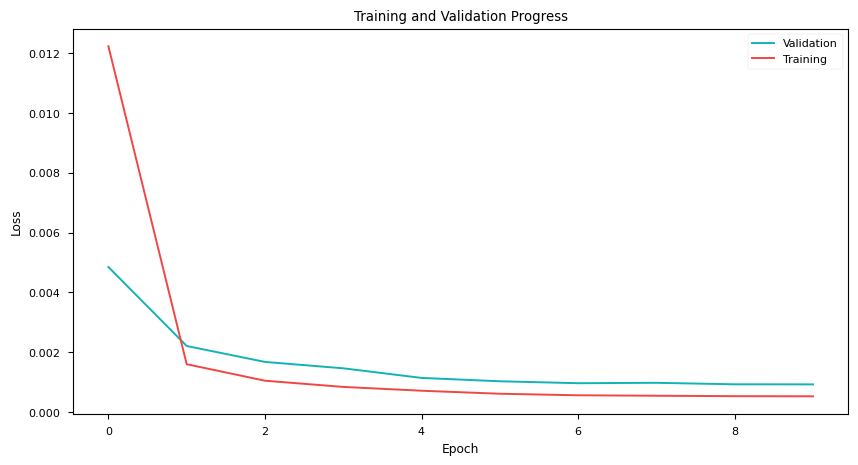

In [44]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 1,
    "out_dim": 1,
    "verbose": True,
    "plots": True,
}
model = train(**params3)

In [45]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

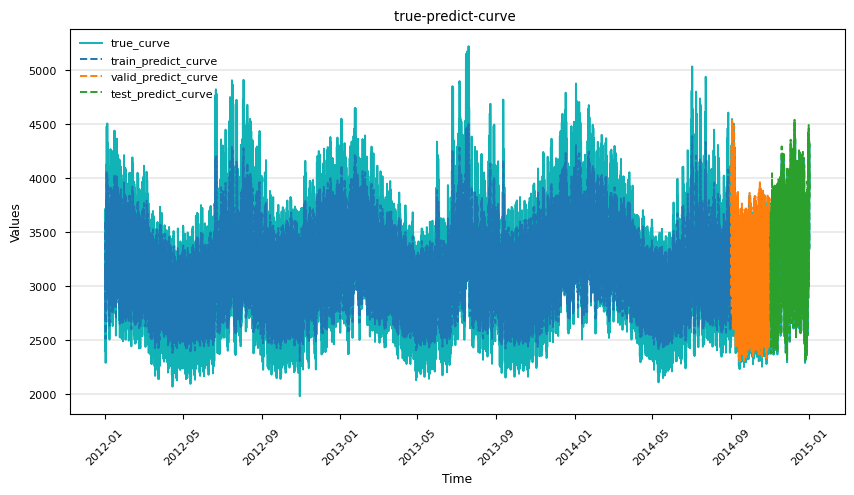

In [46]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

In [47]:
# # 全局动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "train_plot_x": train_plot_x,
#     "train_plot_y": train_plot_y,
#     "valid_plot_x": valid_plot_x,
#     "valid_plot_y": valid_plot_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_full_timeseries(**params6)

# 基于CNN（卷积神经网络）的时间序列预测

**数据输入维度一般为(样本数,特征,时间步)，输出数据维度一般为(样本数,特征)。**

## 数据准备

In [48]:
# 利用前lookback个数据，预测下delay个数据
def cnn_create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据，step为每个多少个采样一次
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.tensor(X)
    y = torch.tensor(y)
    X = X.permute(0,2,1)
    y = y.squeeze(dim=2) #去掉维度为1的第三维度，将其变为二维
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

## 模型训练

In [49]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, seq_length, verbose=True, plots=True):
    # 定义一维CNN模型
    class CNN(nn.Module):
        def __init__(self, input_dim, out_dim, seq_length, num_layers):
            super(CNN, self).__init__()
            layers = []
            in_channels = input_dim
            for _ in range(num_layers):
                # 保证输出维度不变，kernel_size=3,padding=1,stride=1
                layers.append(nn.Conv1d(in_channels=in_channels,
                                        out_channels=64,
                                        kernel_size=3,
                                        padding=1))
                layers.append(nn.ReLU())
                in_channels = 64  # 调整输入通道数
            # kernel_size： 池化窗口的大小，用于指定在每个维度上池化操作的窗口大小。
            # stride： 池化操作的步幅，用于指定在每个维度上滑动池化窗口的步幅。
            # padding： 输入的每一边添加零值的数量，以控制池化操作的形状。
            # dilation： 池化窗口中元素之间的间隔，可以用于增加感受野。
            self.pool = nn.MaxPool1d(kernel_size=2,
                                     stride=2,
                                     padding=0,
                                     dilation=1)  # 长度减少了一半
            self.conv_layers = nn.Sequential(*layers)
            # 将多维的输入数据展平为一维
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(in_features=(in_channels//2)*seq_length,
                                 out_features=64)
            self.fc2 = nn.Linear(64, out_dim)

        def forward(self, x):
            x = self.conv_layers(x)
            x = self.pool(x)
            x = self.flatten(x)
            x = self.fc1(x)
            x = nn.functional.relu(x)
            x = self.fc2(x)
            return x

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 初始化模型、损失函数和优化器，sequence_length时间步，num_layersCNN层数
    model = CNN(input_dim=input_dim,
                out_dim=out_dim,
                seq_length=seq_length,
                num_layers=1).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            # 将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch) # outputs输出维度为二维
            train_loss = loss_fn(outputs, targets_batch)  # targets_batch维度为二维
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                # 将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(
                f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # 绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

## 模型预测

In [50]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad(): 
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        if delay > 1:
            y_pred = model(X_train)
        else:
            y_pred = model(X_train)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        y_pred = y_pred[:, -1] # 取最后一个值作为预测值
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        if delay > 1:
            y_pred = model(X_valid)
        else:
            y_pred = model(X_valid)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:, -1] # 取最后一个值作为预测值
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        if delay > 1:
            y_pred = model(X_test)
        else:
            y_pred = model(X_test)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:, -1] # 取最后一个值作为预测值
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

## 单输入单输出单步预测

In [51]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [52]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1,
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 1, 6]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:02<00:25,  2.86s/it]

Epoch [1/10], Training Loss: 0.0219, Validation Loss: 0.0077


 20%|████████████████▌                                                                  | 2/10 [00:05<00:20,  2.60s/it]

Epoch [2/10], Training Loss: 0.0030, Validation Loss: 0.0040


 30%|████████████████████████▉                                                          | 3/10 [00:07<00:17,  2.54s/it]

Epoch [3/10], Training Loss: 0.0016, Validation Loss: 0.0024


 40%|█████████████████████████████████▏                                                 | 4/10 [00:10<00:14,  2.49s/it]

Epoch [4/10], Training Loss: 0.0011, Validation Loss: 0.0018


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:12<00:11,  2.38s/it]

Epoch [5/10], Training Loss: 0.0009, Validation Loss: 0.0015


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:14<00:09,  2.30s/it]

Epoch [6/10], Training Loss: 0.0008, Validation Loss: 0.0013


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:16<00:06,  2.23s/it]

Epoch [7/10], Training Loss: 0.0007, Validation Loss: 0.0011


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:18<00:04,  2.18s/it]

Epoch [8/10], Training Loss: 0.0006, Validation Loss: 0.0011


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:20<00:02,  2.13s/it]

Epoch [9/10], Training Loss: 0.0006, Validation Loss: 0.0010


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]

Epoch [10/10], Training Loss: 0.0006, Validation Loss: 0.0011


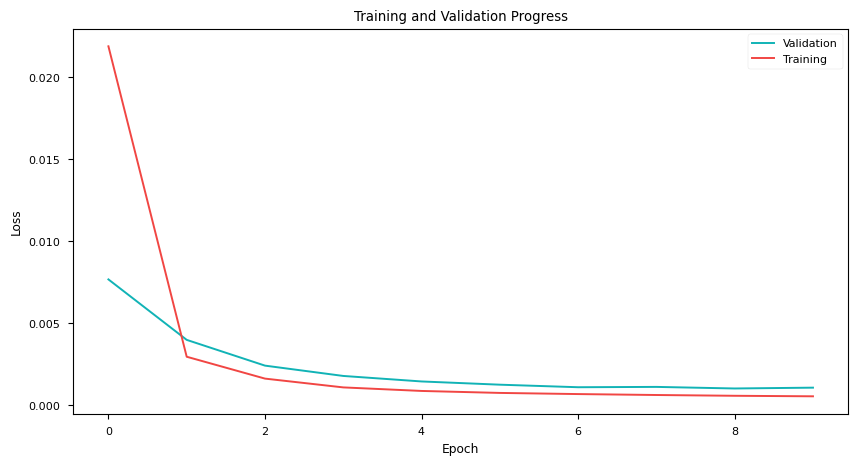

In [53]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 1,
    "out_dim": 1,
    "seq_length": 6, # seq_length=lookback
    "verbose": True,
    "plots": True,
}
model = train(**params3)

In [54]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

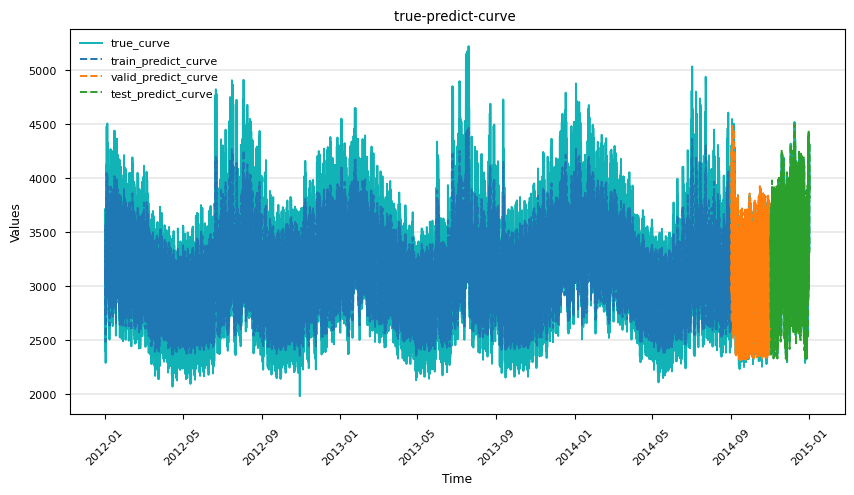

In [55]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

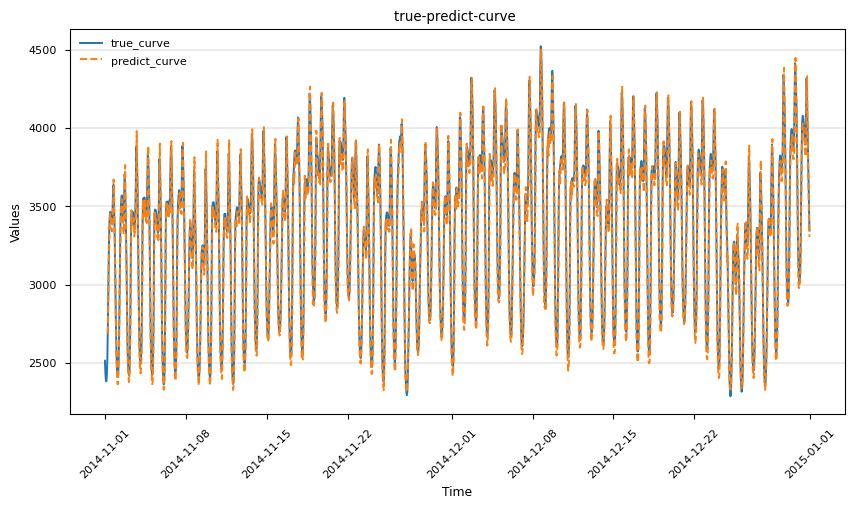

In [56]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

In [57]:
# # 全局动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "train_plot_x": train_plot_x,
#     "train_plot_y": train_plot_y,
#     "valid_plot_x": valid_plot_x,
#     "valid_plot_y": valid_plot_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_full_timeseries(**params6)

## 单输入单输出多步预测

In [58]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [59]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1,
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 1, 6]),y_size: torch.Size([23368, 3]),loader_len: 731
X_size: torch.Size([1456, 1, 6]),y_size: torch.Size([1456, 3]),loader_len: 46
X_size: torch.Size([1456, 1, 6]),y_size: torch.Size([1456, 3]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:02<00:19,  2.17s/it]

Epoch [1/10], Training Loss: 0.0214, Validation Loss: 0.0157


 20%|████████████████▌                                                                  | 2/10 [00:03<00:15,  1.96s/it]

Epoch [2/10], Training Loss: 0.0076, Validation Loss: 0.0119


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:13,  1.89s/it]

Epoch [3/10], Training Loss: 0.0060, Validation Loss: 0.0102


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.96s/it]

Epoch [4/10], Training Loss: 0.0050, Validation Loss: 0.0088


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.98s/it]

Epoch [5/10], Training Loss: 0.0045, Validation Loss: 0.0082


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:08,  2.02s/it]

Epoch [6/10], Training Loss: 0.0041, Validation Loss: 0.0077


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:14<00:06,  2.04s/it]

Epoch [7/10], Training Loss: 0.0039, Validation Loss: 0.0074


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:16<00:04,  2.04s/it]

Epoch [8/10], Training Loss: 0.0036, Validation Loss: 0.0067


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:18<00:02,  2.05s/it]

Epoch [9/10], Training Loss: 0.0035, Validation Loss: 0.0065


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]

Epoch [10/10], Training Loss: 0.0033, Validation Loss: 0.0064


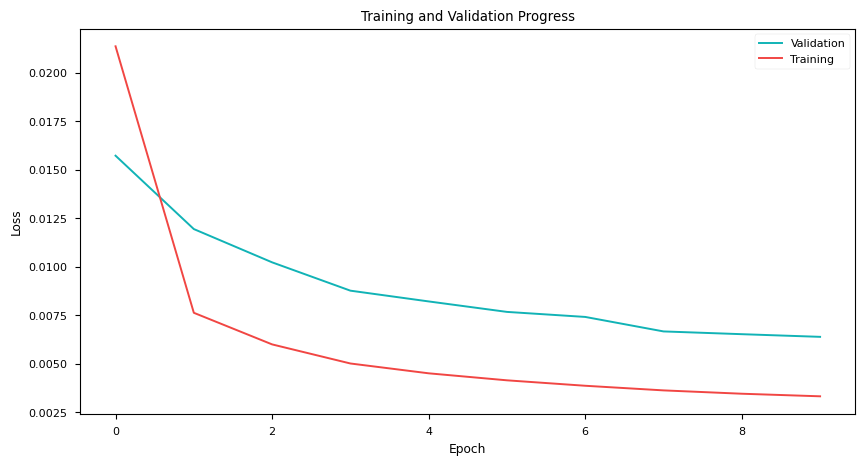

In [60]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 1,
    "out_dim": 3,
    "seq_length": 6, # seq_length=lookback
    "verbose": True,
    "plots": True,
}
model = train(**params3)

In [61]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 3,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

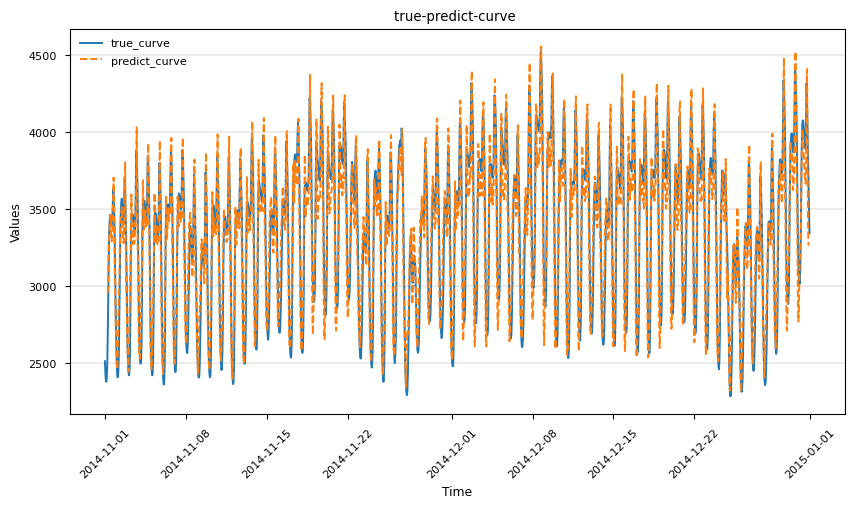

In [62]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

In [63]:
# # 局部动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_part_timeseries(**params6)

## 多输入单输出单步预测

In [64]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [65]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1, #确保后续画图不出错
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 2, 6]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 2, 6]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 2, 6]),y_size: torch.Size([1458, 1]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:02<00:19,  2.20s/it]

Epoch [1/10], Training Loss: 0.0148, Validation Loss: 0.0078


 20%|████████████████▌                                                                  | 2/10 [00:04<00:16,  2.07s/it]

Epoch [2/10], Training Loss: 0.0026, Validation Loss: 0.0052


 30%|████████████████████████▉                                                          | 3/10 [00:06<00:13,  1.99s/it]

Epoch [3/10], Training Loss: 0.0016, Validation Loss: 0.0038


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.95s/it]

Epoch [4/10], Training Loss: 0.0011, Validation Loss: 0.0030


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.85s/it]

Epoch [5/10], Training Loss: 0.0009, Validation Loss: 0.0026


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  1.79s/it]

Epoch [6/10], Training Loss: 0.0007, Validation Loss: 0.0021


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:12<00:05,  1.74s/it]

Epoch [7/10], Training Loss: 0.0007, Validation Loss: 0.0019


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:14<00:03,  1.71s/it]

Epoch [8/10], Training Loss: 0.0006, Validation Loss: 0.0017


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:16<00:01,  1.69s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0017


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0016


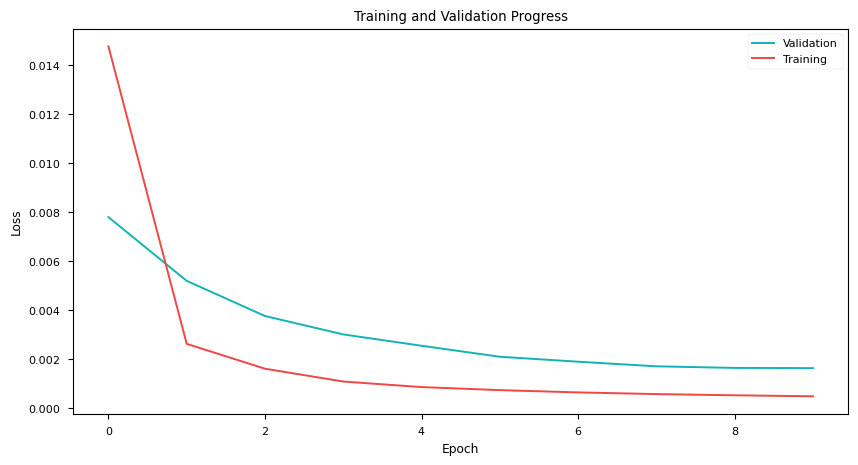

In [66]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 2,
    "out_dim": 1,
    "seq_length": 6, # seq_length=lookback
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [67]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

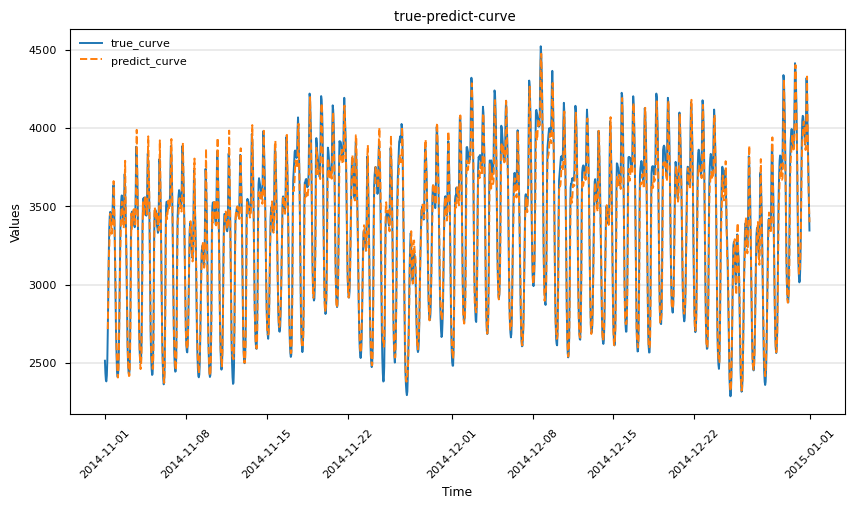

In [68]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

## 多输入单输出多步预测

In [69]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [70]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, #确保后续画图不出错
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 2, 6]),y_size: torch.Size([23368, 3]),loader_len: 731
X_size: torch.Size([1456, 2, 6]),y_size: torch.Size([1456, 3]),loader_len: 46
X_size: torch.Size([1456, 2, 6]),y_size: torch.Size([1456, 3]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:01<00:16,  1.84s/it]

Epoch [1/10], Training Loss: 0.0197, Validation Loss: 0.0161


 20%|████████████████▌                                                                  | 2/10 [00:03<00:13,  1.73s/it]

Epoch [2/10], Training Loss: 0.0070, Validation Loss: 0.0114


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:11,  1.68s/it]

Epoch [3/10], Training Loss: 0.0050, Validation Loss: 0.0094


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.65s/it]

Epoch [4/10], Training Loss: 0.0039, Validation Loss: 0.0081


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.66s/it]

Epoch [5/10], Training Loss: 0.0034, Validation Loss: 0.0082


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:06,  1.65s/it]

Epoch [6/10], Training Loss: 0.0031, Validation Loss: 0.0074


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:05,  1.74s/it]

Epoch [7/10], Training Loss: 0.0029, Validation Loss: 0.0068


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.80s/it]

Epoch [8/10], Training Loss: 0.0027, Validation Loss: 0.0063


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:15<00:01,  1.77s/it]

Epoch [9/10], Training Loss: 0.0026, Validation Loss: 0.0059


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]

Epoch [10/10], Training Loss: 0.0025, Validation Loss: 0.0054


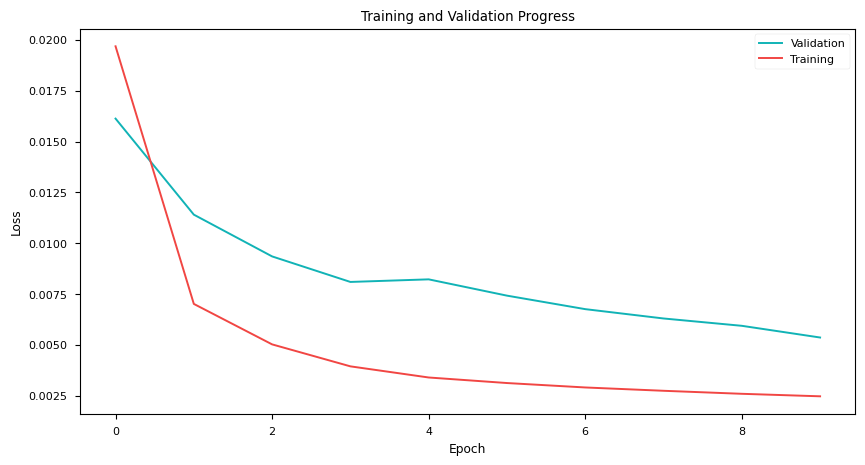

In [71]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 2,
    "out_dim": 3,
    "seq_length": 6, # seq_length=lookback
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [72]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 3,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

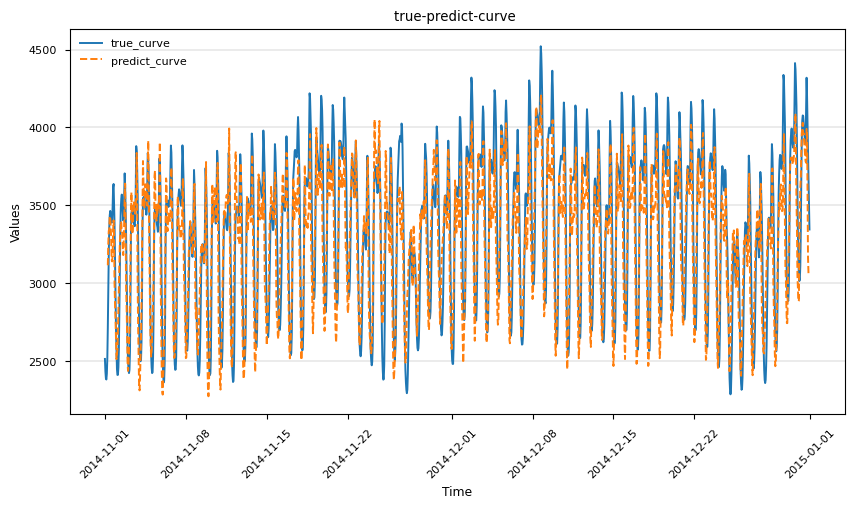

In [73]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

In [74]:
# # 局部动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_part_timeseries(**params6)

# 基于CNN+LSTM的时间序列预测

**CNN用于提取输入数据的特征，LSTM用于捕捉时间序列数据的长期依赖性。**

一维卷积神经网络（1D CNN）通常用于处理时序数据，例如时间序列或信号数据。这种网络结构可以有效地捕获时序数据中的局部模式和趋势。

## 数据准备

In [75]:
# 利用前lookback个数据，预测下delay个数据
def cnn_create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据，step为每个多少个采样一次
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.tensor(X)
    y = torch.tensor(y)
    X = X.permute(0,2,1)
    y = y.squeeze(dim=2) #去掉维度为1的第三维度，将其变为二维
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

## 模型训练

In [76]:
def train(train_loader, valid_loader, n_epochs, input_dim, hidden_dim, out_dim, verbose=True, plots=True):
    # 定义一维CNN模型
    class CNN(nn.Module):
        def __init__(self, input_dim):
            super(CNN, self).__init__()
            layers = []
            num_layers = 1
            in_channels = input_dim
            for _ in range(num_layers):
                # 保证输出维度不变，kernel_size=3,padding=1,stride=1
                layers.append(nn.Conv1d(in_channels=in_channels,
                                        out_channels=hidden_dim,
                                        kernel_size=3,
                                        padding=1))
                layers.append(nn.ReLU())
                in_channels = hidden_dim  # 调整输入通道数
            self.conv_layers = nn.Sequential(*layers)
                
        def forward(self, x):
            x = self.conv_layers(x) 
            return x
                
    # 定义LSTM
    class LSTM(nn.Module):
        def __init__(self, hidden_dim, out_dim):
            super().__init__()
            self.hidden_size = hidden_dim // 2 # 隐藏层设为输入的一半
            self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=self.hidden_size, num_layers=1, batch_first=True)
            self.linear = nn.Linear(in_features=self.hidden_size, out_features=out_dim)
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x

    #定义CNN+LSTM
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim):
            super(Seq2Seq, self).__init__()
            self.cnn = CNN(input_dim)
            self.rnn = LSTM(hidden_dim, out_dim)

        def forward(self, x):
            x = self.cnn(x) # cnn的输出维度为（batch数，特征数，时间步）
            x = x.permute(0, 2, 1) # rnn的输入维度为（batch数，时间步，特征数）
            
            x = self.rnn(x)
            return x  

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 初始化模型、损失函数和优化器
    model = Seq2Seq(input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    out_dim=out_dim).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            # 将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch) 
            outputs = outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
            train_loss = loss_fn(outputs, targets_batch)  # targets_batch维度为二维
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                # 将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_outputs = val_outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
                val_loss = loss_fn(val_outputs, targets_batch)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(
                f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # 绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

## 模型预测

In [77]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出，并将其变为二维
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

## 单输入单输出单步预测

In [78]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [79]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1,
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 1, 6]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:03<00:28,  3.18s/it]

Epoch [1/10], Training Loss: 0.0267, Validation Loss: 0.0163


 20%|████████████████▌                                                                  | 2/10 [00:06<00:25,  3.16s/it]

Epoch [2/10], Training Loss: 0.0048, Validation Loss: 0.0052


 30%|████████████████████████▉                                                          | 3/10 [00:09<00:22,  3.17s/it]

Epoch [3/10], Training Loss: 0.0023, Validation Loss: 0.0038


 40%|█████████████████████████████████▏                                                 | 4/10 [00:12<00:18,  3.06s/it]

Epoch [4/10], Training Loss: 0.0017, Validation Loss: 0.0027


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:15<00:14,  2.94s/it]

Epoch [5/10], Training Loss: 0.0013, Validation Loss: 0.0020


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:18<00:12,  3.13s/it]

Epoch [6/10], Training Loss: 0.0010, Validation Loss: 0.0016


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:21<00:09,  3.11s/it]

Epoch [7/10], Training Loss: 0.0008, Validation Loss: 0.0014


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:24<00:06,  3.00s/it]

Epoch [8/10], Training Loss: 0.0007, Validation Loss: 0.0012


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:27<00:02,  2.91s/it]

Epoch [9/10], Training Loss: 0.0007, Validation Loss: 0.0011


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.99s/it]

Epoch [10/10], Training Loss: 0.0006, Validation Loss: 0.0011


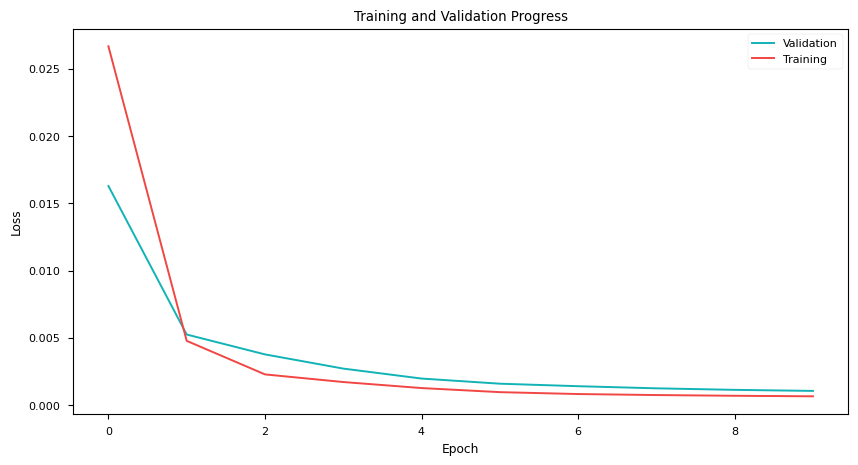

In [80]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 1,
    "hidden_dim": 64,
    "out_dim": 1, 
    "verbose": True,
    "plots": True,
}
model = train(**params3)

In [81]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

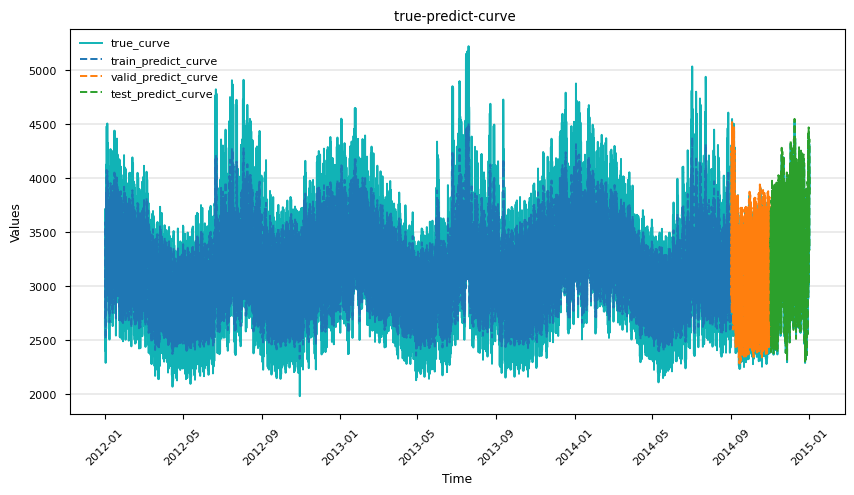

In [82]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

In [83]:
# # 全局动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "train_plot_x": train_plot_x,
#     "train_plot_y": train_plot_y,
#     "valid_plot_x": valid_plot_x,
#     "valid_plot_y": valid_plot_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_full_timeseries(**params6)

## 多输入单输出多步预测

In [94]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [95]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1,
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 2, 6]),y_size: torch.Size([23368, 3]),loader_len: 731
X_size: torch.Size([1456, 2, 6]),y_size: torch.Size([1456, 3]),loader_len: 46
X_size: torch.Size([1456, 2, 6]),y_size: torch.Size([1456, 3]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:02<00:22,  2.51s/it]

Epoch [1/10], Training Loss: 0.1403, Validation Loss: 0.0389


 20%|████████████████▌                                                                  | 2/10 [00:04<00:19,  2.44s/it]

Epoch [2/10], Training Loss: 0.0214, Validation Loss: 0.0314


 30%|████████████████████████▉                                                          | 3/10 [00:07<00:16,  2.42s/it]

Epoch [3/10], Training Loss: 0.0160, Validation Loss: 0.0285


 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:14,  2.48s/it]

Epoch [4/10], Training Loss: 0.0141, Validation Loss: 0.0258


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:12<00:12,  2.52s/it]

Epoch [5/10], Training Loss: 0.0126, Validation Loss: 0.0230


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:15<00:10,  2.57s/it]

Epoch [6/10], Training Loss: 0.0109, Validation Loss: 0.0200


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:18<00:08,  2.84s/it]

Epoch [7/10], Training Loss: 0.0092, Validation Loss: 0.0170


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:21<00:05,  2.86s/it]

Epoch [8/10], Training Loss: 0.0075, Validation Loss: 0.0140


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:25<00:03,  3.13s/it]

Epoch [9/10], Training Loss: 0.0061, Validation Loss: 0.0120


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.80s/it]

Epoch [10/10], Training Loss: 0.0053, Validation Loss: 0.0112


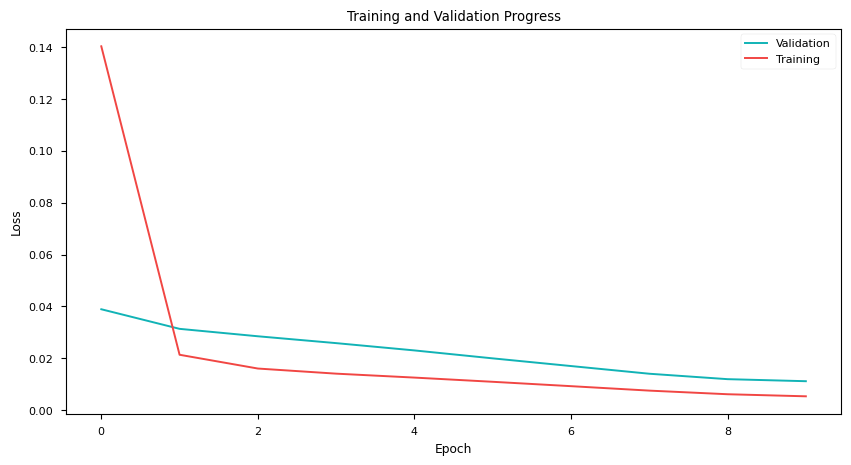

In [96]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 2,
    "hidden_dim": 64,
    "out_dim": 3, 
    "verbose": True,
    "plots": True,
}
model = train(**params3)

In [97]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 3,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

In [99]:
# # 全局动态图
# params6 = {
#     "timeseries_x": timeseries_x,
#     "timeseries_y": timeseries_y,
#     "train_plot_x": train_plot_x,
#     "train_plot_y": train_plot_y,
#     "valid_plot_x": valid_plot_x,
#     "valid_plot_y": valid_plot_y,
#     "test_plot_x": test_plot_x,
#     "test_plot_y": test_plot_y,
# }
# dynamic_full_timeseries(**params6)

# 基于CNN+GRU的时间序列预测

## 数据准备

In [84]:
# 利用前lookback个数据，预测下delay个数据
def cnn_create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据，step为每个多少个采样一次
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.tensor(X)
    y = torch.tensor(y)
    X = X.permute(0,2,1)
    y = y.squeeze(dim=2) #去掉维度为1的第三维度，将其变为二维
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

## 模型训练

In [85]:
def train(train_loader, valid_loader, n_epochs, input_dim, hidden_dim, out_dim, verbose=True, plots=True):
    # 定义一维CNN模型
    class CNN(nn.Module):
        def __init__(self, input_dim):
            super(CNN, self).__init__()
            layers = []
            num_layers = 1
            in_channels = input_dim
            for _ in range(num_layers):
                # 保证输出维度不变，kernel_size=3,padding=1,stride=1
                layers.append(nn.Conv1d(in_channels=in_channels,
                                        out_channels=hidden_dim,
                                        kernel_size=3,
                                        padding=1))
                layers.append(nn.ReLU())
                in_channels = hidden_dim  # 调整输入通道数
            self.conv_layers = nn.Sequential(*layers)
                
        def forward(self, x):
            x = self.conv_layers(x) 
            return x
                
    # 定义GRU
    class GRU(nn.Module):
        def __init__(self, input_dim, out_dim):
            super().__init__()
            self.gru = nn.GRU(input_size=input_dim, hidden_size=5, num_layers=1, batch_first=True)
            self.linear = nn.Linear(in_features=5, out_features=out_dim) 
        def forward(self, x):
            x, _ = self.gru(x)
            x = self.linear(x)
            return x

    #定义CNN+GRU
    class Seq2Seq(nn.Module):
        def __init__(self, input_dim, hidden_dim, out_dim):
            super(Seq2Seq, self).__init__()
            self.cnn = CNN(input_dim)
            self.rnn = GRU(hidden_dim, out_dim)

        def forward(self, x):
            x = self.cnn(x) # cnn的输出维度为（batch数，特征数，时间步）
            x = x.permute(0, 2, 1) # rnn的输入维度为（batch数，时间步，特征数）
            
            x = self.rnn(x)
            return x  

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 初始化模型、损失函数和优化器
    model = Seq2Seq(input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    out_dim=out_dim).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            # 将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch) 
            outputs = outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
            train_loss = loss_fn(outputs, targets_batch)  # targets_batch维度为二维
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                # 将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_outputs = val_outputs[:,-1, -1:] # 取最后一个值，并将其变为二维
                val_loss = loss_fn(val_outputs, targets_batch)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(
                f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # 绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

## 模型预测

In [86]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, -1:] #取最后一个输出，并将其变为二维
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, -1, -1:]
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

## 单输入单输出单步预测

In [87]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 1) y_train shape: (23376, 1)
x_valid shape: (1464, 1) y_valid shape: (1464, 1)
x_test shape: (1464, 1) y_test shape: (1464, 1)


In [88]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1,
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 1, 6]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 1, 6]),y_size: torch.Size([1458, 1]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:02<00:23,  2.65s/it]

Epoch [1/10], Training Loss: 0.1598, Validation Loss: 0.0254


 20%|████████████████▌                                                                  | 2/10 [00:05<00:23,  2.88s/it]

Epoch [2/10], Training Loss: 0.0117, Validation Loss: 0.0173


 30%|████████████████████████▉                                                          | 3/10 [00:08<00:20,  2.94s/it]

Epoch [3/10], Training Loss: 0.0077, Validation Loss: 0.0130


 40%|█████████████████████████████████▏                                                 | 4/10 [00:11<00:17,  2.87s/it]

Epoch [4/10], Training Loss: 0.0058, Validation Loss: 0.0099


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:14<00:14,  2.97s/it]

Epoch [5/10], Training Loss: 0.0042, Validation Loss: 0.0069


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:17<00:11,  2.88s/it]

Epoch [6/10], Training Loss: 0.0027, Validation Loss: 0.0044


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:20<00:08,  2.99s/it]

Epoch [7/10], Training Loss: 0.0018, Validation Loss: 0.0031


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:23<00:05,  2.99s/it]

Epoch [8/10], Training Loss: 0.0013, Validation Loss: 0.0024


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:26<00:02,  2.93s/it]

Epoch [9/10], Training Loss: 0.0011, Validation Loss: 0.0019


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.96s/it]

Epoch [10/10], Training Loss: 0.0008, Validation Loss: 0.0016


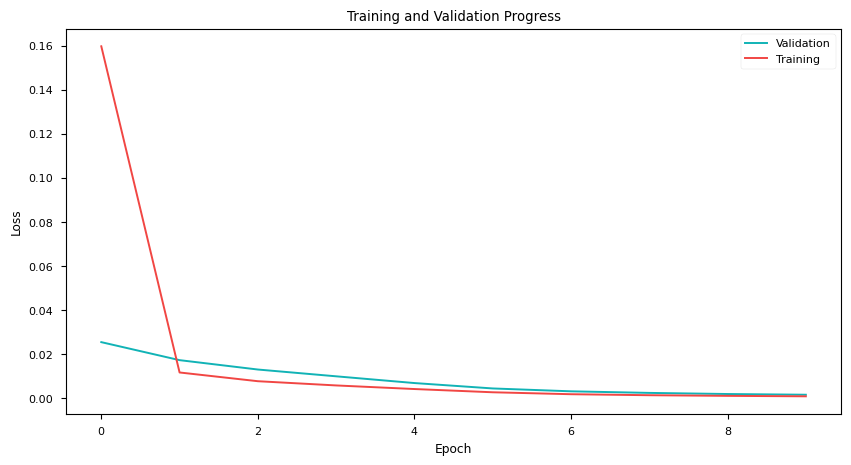

In [89]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 1,
    "hidden_dim": 64,
    "out_dim": 1, 
    "verbose": True,
    "plots": True,
}
model = train(**params3)

In [90]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

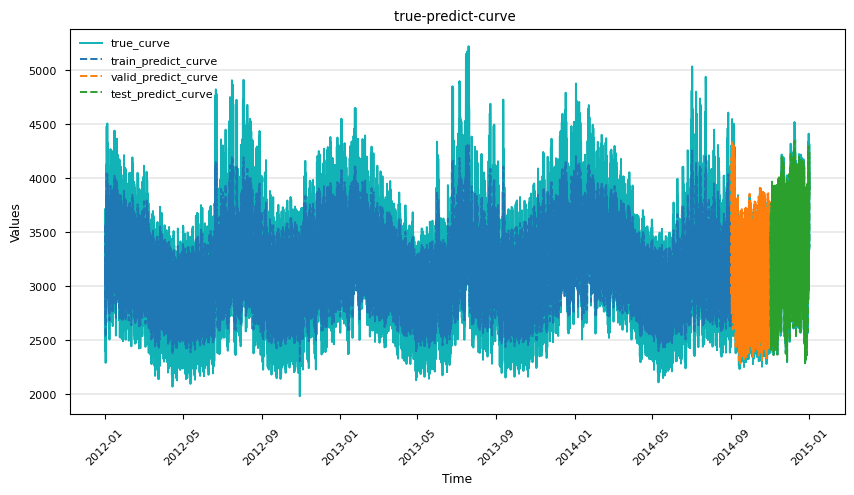

In [91]:
# 全局静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "train_plot_x": train_plot_x,
    "train_plot_y": train_plot_y,
    "valid_plot_x": valid_plot_x,
    "valid_plot_y": valid_plot_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_full_timeseries(**params5)

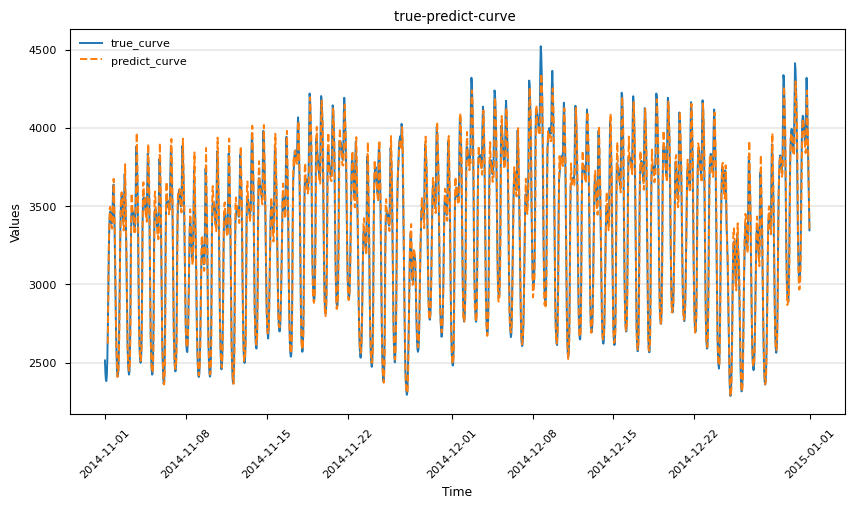

In [92]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

# 基于TCN（时域卷积网络）的时间序列预测

## 算法原理

该算法于2016年由Lea等人他们在做视频动作分割的研究首先提出，TCN模型以 CNN 模型为基础，并做了如下改进：①适用序列模型：因果卷积（Causal Convolution）②记忆历史：空洞卷积/膨胀卷积（Dilated Convolution），残差模块（Residual block）。

 RNN耗时太长，由于网络一次只读取、解析输入文本中的一个单词（或字符），深度神经网络必须等前一个单词处理完，才能进行下一个单词的处理。这意味着 RNN 不能像 CNN 那样进行大规模并行处理；并且TCN的实际结果也要优于RNN算法。

TCN可以采用一系列任意长度并将其输出为相同长度。在使用一维完全卷积网络体系结构的情况下，使用因果卷积。一个关键特征是，时间t的输出仅与t之前发生的元素卷积。

### 因果卷积

![hellworld](../images/p29.png)

**因果卷积**可以用上图直观表示。 即对于上一层t时刻的值，只依赖于下一层t时刻及其之前的值。和传统的卷积神经网络的不同之处在于，因果卷积不能看到未来的数据，它是单向的结构，不是双向的。也就是说只有有了前面的因才有后面的果，是一种严格的时间约束模型，因此被成为因果卷积。

因果卷积有两个特点：
- 不考虑未来的信息。给定输入序列$x_1,x_2,...,x_T$ ，预测$y_1,y_2,...,y_T$ 。但是在预测$y_t$时，只能使用已经观测到的序列$x_1,x_2,...,x_T$ ，而不能使用$x_{t+1},x_{t+2},...$  。
- 追溯历史信息越久远，隐藏层越多。上图中，假设我们以第二层隐藏层作为输出，它的最后一个节点关联了输入的三个节点，即$x_{t-2},x_{t-1},x_t$  ；假设以输出层作为输出，它的最后一个节点关联了输入的五个节点。

### 空洞卷积/膨胀卷积

单纯的因果卷积还是存在传统卷积神经网络的问题，即对时间的建模长度受限于卷积核大小，如果要想抓去更长的依赖关系，就需要线性的堆叠很多的层。标准的 CNN 可以通过增加 pooling 层来获得更大的感受野，而经过 pooling 层后肯定存在信息损失的问题。

空洞卷积是在标准的卷积里注入空洞，以此来增加感受野。空洞卷积多了一个超参数 dilation rate，指的是 kernel 的间隔数量（标准的 CNN 中 dilatation rate 等于 1）。空洞的好处是不做 pooling 损失信息的情况下，增加了感受野，让每个卷积输出都包含较大范围的信息。下图展示了标准 CNN （左）和 Dilated Convolution （右），右图中的 dilatation rate 等于 2 。 

![hellworld](../images/p30.png)

和传统卷积不同的是，膨胀卷积允许卷积时的输入存在间隔采样，采样率受图中的d控制。 最下面一层的d=1，表示输入时每个点都采样，中间层d=2，表示输入时每2个点采样一个作为输入。一般来讲，越高的层级使用的d的大小越大。所以，膨胀卷积使得有效窗口的大小随着层数呈指数型增长。这样卷积网络用比较少的层，就可以获得很大的感受野。

![hellworld](../images/p31.png)

因为研究对象是时间序列，TCN 采用一维的卷积网络。上图是 TCN 架构中的因果卷积与空洞卷积，可以看到每一层t时刻的值只依赖于上一层t,t-1,...时刻的值，体现了因果卷积的特性；而每一层对上一层信息的提取，都是跳跃式的，且逐层 dilated rate 以 2 的指数增长，体现了空洞卷积的特性。由于采用了空洞卷积，因此每一层都要做 padding（通常情况下补 0），padding 的大小为 (k-1)d 。 

### 残差模块

![hellworld](../images/p32.png)

残差链接被证明是训练深层网络的有效方法，它使得网络可以以跨层的方式传递信息。本文构建了一个残差块来代替一层的卷积。如上图所示，一个残差块包含两层的卷积和非线性映射，在每层中还加入了WeightNorm和Dropout来正则化网络。

优点：
- **并行性（Parallelism）**。与在 RNN 中对后续时间步的预测必须等待其前任完成的情况不同，卷积可以并行完成，因为每一层都使用相同的滤波器。因此，在训练和评估中，长输入序列可以在 TCN 中作为一个整体进行处理，而不是像在 RNN 中那样按顺序处理。
- **灵活的感受野大小（Flexible receptive field size）**。TCN 可以通过多种方式改变其感受野大小。例如，堆叠更多扩张（因果）卷积层、使用更大的膨胀因子或增加滤波器大小都是可行的选择（可能有不同的解释）。因此，TCN 可以更好地控制模型的内存大小，并且易于适应不同的领域。
- **稳定的梯度（Stable gradients）**。与循环架构不同，TCN 的反向传播路径与序列的时间方向不同。因此，TCN 避免了梯度爆炸/消失的问题，这是 RNN 的一个主要问题，并导致了 LSTM、GRU、HF-RNN（Martens & Sutskever，2011）等的发展。
- **训练时内存要求低**。特别是在输入序列较长的情况下，LSTM 和 GRU 很容易占用大量内存来存储它们的多个单元门的部分结果。而在 TCN 中，滤波器跨层共享，反向传播路径仅取决于网络深度。因此，在实践中，我们发现门控 RNN 可能比 TCN 使用更多的内存。
- **可变长度输入**。就像 RNN 以循环方式对可变长度的输入进行建模一样，TCN 也可以通过滑动 1D 卷积核来接收任意长度的输入。这意味着 TCN 可以作为 RNN 的替代品，用于任意长度的序列数据。

缺点：
- **评估期间的数据存储**。在评估/测试中，RNN 只需保持隐藏状态并获取当前输入 xt 即可生成预测。换句话说，整个历史的“摘要”由一组固定长度的向量 ht 提供，而实际观察到的序列可以被丢弃。相比之下，TCN 需要接收到有效历史长度的原始序列，因此在评估期间可能需要更多内存。
- **域迁移的潜在参数变化（Potential parameter change for a transfer of domain）**。不同领域对模型预测所需的历史数量可能有不同的要求。因此，当将模型从只需要很少内存的域（即小 k 和 d）转移到需要更长内存的域（即大得多的 k 和 d）时，TCN 可能会因为没有足够大的感受野。

## 数据准备

In [12]:
# 利用前lookback个数据，预测下delay个数据
def cnn_create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据，step为每个多少个采样一次
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.tensor(X)
    y = torch.tensor(y)
    X = X.permute(0,2,1)
    y = y.squeeze(dim=2) #去掉维度为1的第三维度，将其变为二维
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

## 模型训练

In [22]:
def train(train_loader, valid_loader, n_epochs, input_dim, out_dim, verbose=True, plots=True):
    class Crop(nn.Module):
        def __init__(self, crop_size):
            super(Crop, self).__init__()
            self.crop_size = crop_size

        def forward(self, x):
            # 裁剪输入张量以去除沿时间维度的多余填充
            return x[:, :, :-self.crop_size].contiguous()

    class TemporalBlock(nn.Module):
        def __init__(self, input_dim, out_dim, kernel_size, stride, dilation, dropout=0.2):
            """
            时序因果层模块，由两个因果卷积块组成，每个卷积块包含卷积、裁剪、ReLU激活和丢弃部分。

            参数:
                - input_dim (int): 输入通道数。
                - out_dim (int): 输出通道数。
                - kernel_size (int): 卷积核大小。
                - stride (int): 卷积步幅。
                - dilation (int): 卷积膨胀率。
                - dropout (float): 丢弃率。
            """
            super(TemporalBlock, self).__init__()
            padding = (kernel_size - 1) * dilation
            conv_params = {
                'kernel_size': kernel_size,
                'stride': stride,
                'padding': padding,
                'dilation': dilation
            }

            # 第一个卷积块
            self.conv1 = weight_norm(nn.Conv1d(input_dim, out_dim, **conv_params))
            self.crop1 = Crop(padding)
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(dropout)

            # 第二个卷积块
            self.conv2 = weight_norm(nn.Conv1d(out_dim, out_dim, **conv_params))
            self.crop2 = Crop(padding)
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(dropout)

            # 两个卷积块的顺序组合
            self.net = nn.Sequential(self.conv1, self.crop1, self.relu1, self.dropout1,
                                     self.conv2, self.crop2, self.relu2, self.dropout2)

            # 快捷连接
            self.bias = nn.Conv1d(input_dim, out_dim, 1) if input_dim != out_dim else None
            self.relu = nn.ReLU()

        def forward(self, x):
            """
            前向传播方法。

            参数:
                - x (Tensor): 输入张量，形状为 (batch_size, input_channels, sequence_length)。

            返回:
                - Tensor: 输出张量，形状为 (batch_size, output_channels, sequence_length)。
            """
            # 应用因果卷积和快捷连接
            y = self.net(x)
            b = x if self.bias is None else self.bias(x)
            return self.relu(y + b)

    class TemporalConvNet(nn.Module):
        def __init__(self, input_dim, input_dims, kernel_size=2, dropout=0.2):
            """
            时序卷积网络模块，由多个时序因果层组成，每个时序因果层采用不同膨胀率的卷积核。

            参数:
                - input_dim (int): 输入通道数。
                - input_dims (list): 包含每个时序因果层输出通道数的列表。
                - kernel_size (int): 卷积核大小。
                - dropout (float): 丢弃率。
            """
            super(TemporalConvNet, self).__init__()
            layers = []
            num_levels = len(input_dims)
            tcl_param = {
                'kernel_size': kernel_size,
                'stride': 1,
                'dropout': dropout
            }

            # 堆叠多个时序因果层
            for i in range(num_levels):
                dilation = 2 ** i
                input_dim = input_dim if i == 0 else input_dims[i - 1]
                out_dim = input_dims[i]
                tcl_param['dilation'] = dilation
                tcl = TemporalBlock(input_dim, out_dim, **tcl_param)
                layers.append(tcl)

            # 时序因果层的顺序组合
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            """
            前向传播方法。

            参数:
                - x (Tensor): 输入张量，形状为 (batch_size, input_channels, sequence_length)。

            返回:
                - Tensor: 输出张量，形状为 (batch_size, output_channels, sequence_length)。
            """
            return self.network(x)

    class TCN(nn.Module):
        def __init__(self, input_dim, out_dim, input_dims, kernel_size=2, dropout=0.2):
            super(TCN, self).__init__()
            # 时间卷积网络
            self.tcn = TemporalConvNet(input_dim, input_dims, kernel_size=kernel_size, dropout=dropout)
            # 用于最终预测的线性层，移除ReLU激活函数
            self.linear = nn.Linear(input_dims[-1], out_dim)

        def forward(self, x):
            """
            前向传播方法。

            参数:
                - x (Tensor): 输入张量，形状为 (batch_size, input_channels, sequence_length)。

            返回:
                - Tensor: 输出张量，形状为 (batch_size, out_dim)。
            """
            # 应用时间卷积网络和线性层
            y = self.tcn(x)  # [N, C_out, L_out=L_in]
            return self.linear(y[:, :, -1])
        
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 初始化模型、损失函数和优化器
    input_dims = [64, 128, 256]  # TCN中每个层的通道数
    model = TCN(input_dim, out_dim, input_dims).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            # 将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch) # outputs输出维度为二维
            train_loss = loss_fn(outputs, targets_batch)  # targets_batch维度为二维
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                # 将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_loss = loss_fn(val_outputs, targets_batch)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(
                f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # 绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

## 模型预测

In [19]:
def predict(model, X_train, X_valid, X_test, y_true, lookback, delay, scaler):
    lookback = lookback - 1 #包含当前时间点
    #数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    #时间序列形状
    timeseries_y = y_true.values
    timeseries_x = y_true.index
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #关闭自动求导功能
    with torch.no_grad(): 
        '''测试集设置'''
        X_train = X_train.to(device) #将数据应用到GPU
        if delay > 1:
            y_pred = model(X_train)
        else:
            y_pred = model(X_train)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        y_pred = y_pred[:, -1] # 取最后一个值作为预测值
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        '''验证集设置'''
        X_valid = X_valid.to(device)
        if delay > 1:
            y_pred = model(X_valid)
        else:
            y_pred = model(X_valid)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:, -1] # 取最后一个值作为预测值
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        '''测试集设置'''
        X_test = X_test.to(device)
        if delay > 1:
            y_pred = model(X_test)
        else:
            y_pred = model(X_test)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:, -1] # 取最后一个值作为预测值
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

## 多输入单输出单步预测

In [23]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [24]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 1,
    "step": 1, #确保后续画图不出错
    "batch_size": 32,
}
X_train, y_train, train_loader = cnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = cnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = cnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 2, 6]),y_size: torch.Size([23370, 1]),loader_len: 731
X_size: torch.Size([1458, 2, 6]),y_size: torch.Size([1458, 1]),loader_len: 46
X_size: torch.Size([1458, 2, 6]),y_size: torch.Size([1458, 1]),loader_len: 46


 10%|████████▎                                                                          | 1/10 [00:16<02:31, 16.84s/it]

Epoch [1/10], Training Loss: 0.0057, Validation Loss: 0.0026


 20%|████████████████▌                                                                  | 2/10 [00:33<02:14, 16.83s/it]

Epoch [2/10], Training Loss: 0.0014, Validation Loss: 0.0024


 30%|████████████████████████▉                                                          | 3/10 [00:51<01:59, 17.13s/it]

Epoch [3/10], Training Loss: 0.0011, Validation Loss: 0.0018


 40%|█████████████████████████████████▏                                                 | 4/10 [01:08<01:42, 17.15s/it]

Epoch [4/10], Training Loss: 0.0008, Validation Loss: 0.0017


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:25<01:25, 17.08s/it]

Epoch [5/10], Training Loss: 0.0007, Validation Loss: 0.0014


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:43<01:09, 17.49s/it]

Epoch [6/10], Training Loss: 0.0006, Validation Loss: 0.0014


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:01<00:53, 17.77s/it]

Epoch [7/10], Training Loss: 0.0005, Validation Loss: 0.0013


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:20<00:36, 18.03s/it]

Epoch [8/10], Training Loss: 0.0005, Validation Loss: 0.0013


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:38<00:18, 18.02s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0013


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.60s/it]

Epoch [10/10], Training Loss: 0.0004, Validation Loss: 0.0013


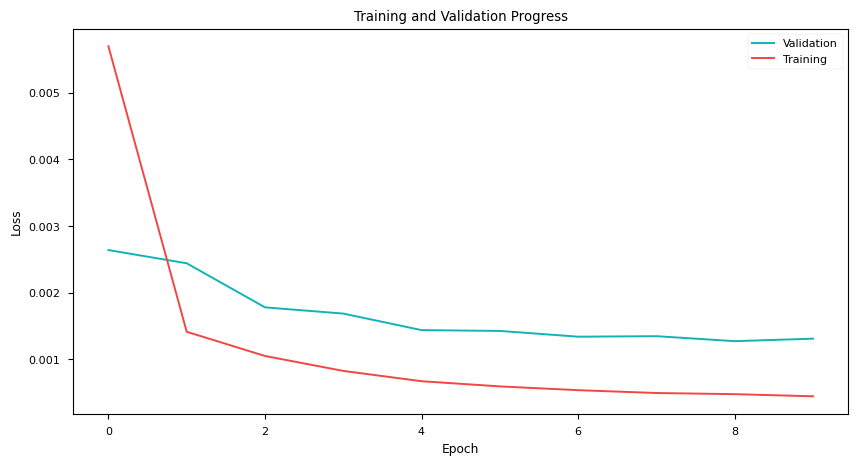

In [25]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 10,
    "input_dim": 2,
    "out_dim": 1,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

In [26]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_true": ts_data[['load']],
    "lookback": 6,
    "delay": 1,
    "scaler": scaler,
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

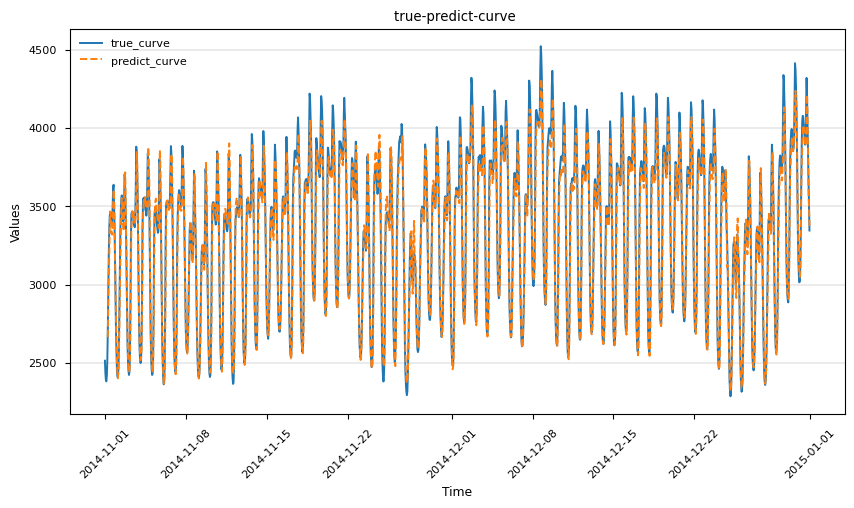

In [27]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)